In [1]:
from pyscf import gto, scf
import pyscf.qmmm
import pyscf.dft
import numpy as np
angstrom = 1 / 0.52917721067
from matplotlib import pyplot as plt

# ancora il modo migliore per mettere cariche frazionali sulle molecole, se vai a toccare mol.charges si incazza 
#  quando deve calcolare l' initial guess 

def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords()/angstrom, deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float)
            for i in range (len(q)):
                q[i] += deltaZ[i] 
            return self.mol.energy_nuc(q)
    return(NoSelfQMMM())

In [2]:
molCO=gto.Mole(atom="C 0 0 0 ; O 0 0 1.06",basis="sto-3G")# basis={'C': gto.basis.load("sto-3G ",'N'),'O': gto.basis.load("sto-3G ",'N')})
molCO.build()
hf=scf.RHF(molCO)
hfnn=fc(hf,[1.,-1])
hf.scf()
hfnn.scf()

converged SCF energy = -111.200776611731
converged SCF energy = -105.427838127191


-105.42783812719127

-105.42783812719127

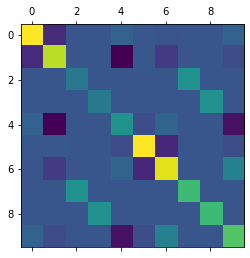

In [3]:
plt.matshow(hf.make_rdm1())
hfnn.e_tot

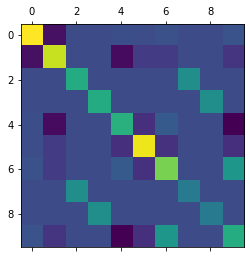

In [4]:
plt.matshow(hfnn.make_rdm1())

In [5]:
print(dir(hf))

['CASCI', 'CASSCF', 'CCSD', 'CISD', 'DFMP2', 'DIIS', 'Gradients', 'MP2', 'QMMM', 'TDA', 'TDHF', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chkfile', '_eigh', '_eri', '_finalize', '_is_mem_enough', '_keys', '_t0', '_w0', 'analyze', 'apply', 'as_scanner', 'build', 'callback', 'canonicalize', 'check_convergence', 'check_sanity', 'chkfile', 'conv_check', 'conv_tol', 'conv_tol_grad', 'converged', 'convert_from_', 'damp', 'damp_factor', 'density_fit', 'diis', 'diis_file', 'diis_space', 'diis_space_rollback', 'diis_start_cycle', 'dip_moment', 'direct_scf', 'direct_scf_tol', 'dump_chk', 'dump_flags', 'e_tot', 'eig', 'energy_elec', 'energy_nuc', 'energy_tot', 'from_chk', 'get_fock', 'get_grad', 'g

In [6]:
S=hf.get_ovlp()
C=hf.mo_coeff
O1=hf.mo_occ
O=np.diag(O1)
P=hf.make_rdm1()
F=hf.get_fock()
h1=hf.get_hcore()
h2=hf.get_veff()
J,K=hf.get_jk()
g_ijkl=hf.mol.intor('int2e_sph')
E=np.diag(hf.mo_energy)
print('COC* = P :', np.allclose(P,C.dot(O.dot(C.T)))) 
print( "J-K/2 = H2 :",np.allclose(h2,J-K/2))
print("J= sum_ij(g_ijklm P_lm ) ",np.allclose(J,np.einsum('ijkl,kl->ij',g_ijkl,P)))
print("K= sum_ik(g_ijklm P_jm ) ",np.allclose(K,np.einsum('ijkl,jl->ik',g_ijkl,P)))

print( "F= H1 +H2 :",np.allclose(F,h1+h2))
print ("numero di elettroni:", S.dot(P).trace())  # numero di elettroni
print("FC=SCE :",np.allclose(np.dot(F,C),S.dot(C.dot(E))))
print("eig(S-1 F) -> C,E ","np.linalg.eig(np.linalg.inv(S).dot(F))" )
print("C*FC = E : ",np.allclose(C.T.dot(F.dot(C))/100,E/100))

COC* = P : True
J-K/2 = H2 : True
J= sum_ij(g_ijklm P_lm )  True
K= sum_ik(g_ijklm P_jm )  True
F= H1 +H2 : True
numero di elettroni: 13.999999999999996
FC=SCE : True
eig(S-1 F) -> C,E  np.linalg.eig(np.linalg.inv(S).dot(F))
C*FC = E :  True


$$ J - K/2 =H_2$$
$$H_1+ H_2 = F $$

$$ V_{ij}^{\alpha} = \sum_{kl} (ij|kl)(\gamma_{lk}^\alpha+\gamma_{lk}^\beta)- \sum_{kl} (il|kj) \gamma_{lk}^{\alpha} \\    V_{ij}^{\beta}  = \sum_{kl} (ij|kl)(\gamma_{lk}^{\alpha}+\gamma_{lk}^{\beta})  - \sum_{kl} (il|kj)\gamma_{lk}^\beta $$

Now getting the energies

$$  E = \sum_{ij}h_{ij} \gamma_{ji} + \frac{1}{2}\sum_{ijkl} \gamma_{ji}\gamma_{lk} \langle ik||jl\rangle $$


In [7]:
e_tot=hf.e_tot 
e_nn=hf.energy_nuc() 
e_ne,e_ee=hf.energy_elec()
e_ne-=e_ee

In [8]:
print(e_tot,e_nn+e_ee+e_ne)
print(e_ne,np.trace(P.dot(h1)))
print(e_ee,np.trace(P.dot(h2))/2)

-111.20077661173107 -111.20077661173106
-199.4486598443554 -199.44865984435543
64.2851416060583 64.2851416060583


Now is to get the alchemical derivatives:
$$ $$

In [224]:
hf0=fc(hf,[.0005,-.0005])
hf0.scf()
C0=hf0.mo_coeff
P0=hf0.make_rdm1()

hf1=fc(hf,[-.0005,.0005])
hf1.scf()
C1=hf1.mo_coeff
P1=hf1.make_rdm1()

converged SCF energy = -111.197134960877
converged SCF energy = -111.204418995007


In [231]:
dC=(C1-C0)/.001
U=np.dot(np.linalg.inv(C),dC)
dP=(P1-P0)/.001

In [193]:
print(np.allclose(dC,C.dot(U)))
print(np.allclose(dC.T,U.T.dot(C.T)))

True
True


In [194]:
print(np.allclose(P,C.dot(O.dot(C.T))))                        #P = COC*
print(np.allclose(P0,C0.dot(O.dot(C0.T))))
print(np.allclose(P1,C1.dot(O.dot(C1.T))))
print(np.allclose(P1-P0,C1.dot(O.dot(C1.T))-C0.dot(O.dot(C0.T))))  # P1-P0 = C_1 O C_1* - C_0 O C_0*

True
True
True
True


In [235]:
print(np.allclose(P1-P0,(C1-C0).dot(O.dot(C1.T))+C0.dot(O.dot((C1-C0).T)))) 
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.linalg.norm(dP-dC.dot(O.dot(C.T))-C.dot(O.dot(dC.T))))
print(np.linalg.norm(dP-dC.dot(O.dot(C1.T))-C0.dot(O.dot(dC.T))))

True
True
True
True
1388.1665105900229
8.481375935576129e-13


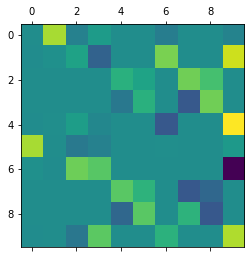

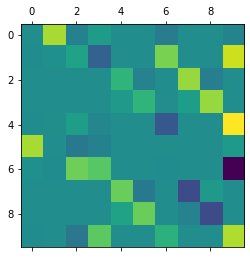

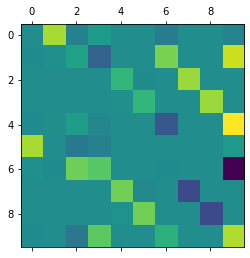

In [226]:
plt.matshow(C0)
plt.matshow(C)
plt.matshow(C1)
#C1[[7,8]]=C1[[8,7]]

1.6683167644857304
0.416705096781726
1.0335785759478864
1.2809017284952677
0.0008940620472015519
1.6227303980801532e-07
0.0008941168118909115


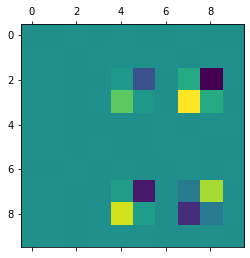

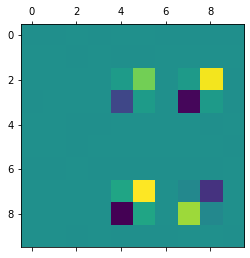

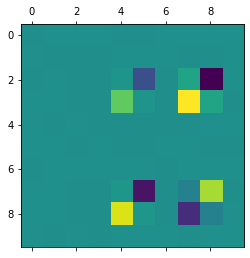

In [236]:
plt.matshow((C-C0))
plt.matshow((C1-C))
plt.matshow(((C-C1)+(C-C0))/2)
print(np.linalg.norm((C-C0)))
print(np.linalg.norm((C1-C)))
print(np.linalg.norm(((C-C1)+(C-C0))/2))
print(np.linalg.norm(C0-C1))

print(np.linalg.norm(P-P0))
print(np.linalg.norm((P1+P0)/2-P))
print(np.linalg.norm(P-P1))

In [247]:
np.allclose(F.dot(C),S.dot(C.dot(E)))

True

In [250]:
dV=(hf1.get_hcore()-hf0.get_hcore())/.001


-6.285586854969709